# 1. Imports

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import scipy

# IMPORT CUSTOM MODULES
import sys
sys.path.append("../")
from BAMVAE.MNISTLoader import MNIST_Loader
from BAMVAE.VAE1 import VAE, loss_function,complete_train_and_test,decompose_loss_function

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Load data & define DataLoaders

In [11]:
device = torch.device("mps") # GPU acceleration for Mac

In [12]:
mnist=MNIST_Loader(bs=128,
    root_folder='../mnist_data')

train_dataset,test_dataset=mnist.__getdatasets__()
train_loader,test_loader=mnist.__getdataloaders__()

# 3. Define model

In [13]:
learning_rate=1e-3
nb_epochs=20
vae=VAE(name=f"VAE_{nb_epochs}_epochs",z_dim=2).to(device)
optimizer= optim.Adam(vae.parameters(),lr=learning_rate)
# dic_VAE={
#     5: dict(vae=VAE(name="VAE_5_epochs").to(device)),

#     10: dict(vae=VAE(name="VAE_10_epochs").to(device)),
#     20: dict(vae=VAE(name="VAE_20_epochs").to(device))
#     }
# for nb_epochs in dic_VAE.keys():
#     vae=dic_VAE[nb_epochs]["vae"]
#     dic_VAE[nb_epochs]["optimizer"]= optim.Adam(vae.parameters(),lr=learning_rate)


In [14]:
nb_params=vae.print_nb_params()

The model has 116 069 parameters


# 3. Train model

In [15]:

# losses=complete_train_and_test(vae,train_loader=train_loader,
#                             test_loader=test_loader,optimizer=optimizer,
#                             nb_epochs=nb_epochs,view_latent=True,
#                             test_dataset=test_dataset,
#                             k1=0.5,k2=0.5)

# vae.save_model(model_path="../models/checkpoint_basic_vae_2d_20epochs.h5")

# for nb_epochs in dic_VAE.keys():
#     print(("##"*10+"\n"))
#     print(f"Training with {nb_epochs}\n")
#     vae=dic_VAE[nb_epochs]["vae"]
#     optimizer=dic_VAE[nb_epochs]["optimizer"]
#     losses=complete_train_and_test(vae,train_loader=train_loader,test_loader=test_loader
#                          ,optimizer=optimizer,nb_epochs=nb_epochs,view_latent=True,test_dataset=test_dataset)
#     dic_VAE[nb_epochs]["losses"]=losses
# vae.save_model(folder="../models/")
# plt.plot(losses)


### Generating images from the latent space with some gaussian noise

In [16]:
# Loading the pretrained model
vae=VAE(name="20epochs").to(device)
vae.load_state_dict(torch.load("../models/checkpoint_basic_vae_2d_20epochs.h5"))

<All keys matched successfully>

tensor([[-3.3302,  3.8082]], device='mps:0') tensor([[-19.0697, -16.7828]], device='mps:0')


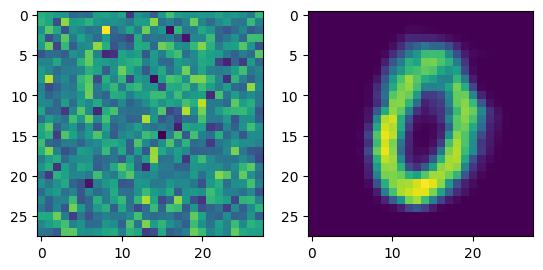

In [46]:
vae.eval()
with torch.no_grad():
    randomIm=np.random.randn(1,1,28,28)
    randomIm=torch.tensor(randomIm,dtype=torch.float32,device=device)
    rec,mu,logvar=vae(randomIm)
    print(mu,logvar)

fig,axs=plt.subplots(1,2)
axs=axs.ravel()
inIm=randomIm.detach().cpu().numpy().reshape(28,28)
recIm=rec.detach().cpu().numpy().reshape(28,28)

axs[0].imshow(inIm)
axs[1].imshow(recIm)


In [22]:
dim_latent_space=2
def generate_from_noise(variance=1.,mean=0,nb_images=10,dim_latent_space=2):
    random_vectors=np.random.randn(nb_images,1,1,dim_latent_space)*variance+mean
    random_vectors=torch.tensor(random_vectors,dtype=torch.float32).to(device)
    return random_vectors
random_vectors=generate_from_noise()
random_vectors_np=random_vectors.detach().cpu().numpy()
print(random_vectors.shape)
random_vectors_np=random_vectors_np.reshape(-1,1,dim_latent_space)

torch.Size([10, 1, 1, 2])


In [23]:
vae.eval()
with torch.no_grad():
    decoded_random=vae.decoder(random_vectors)
decoded_random=decoded_random.detach().cpu().numpy().reshape(-1,28,28)

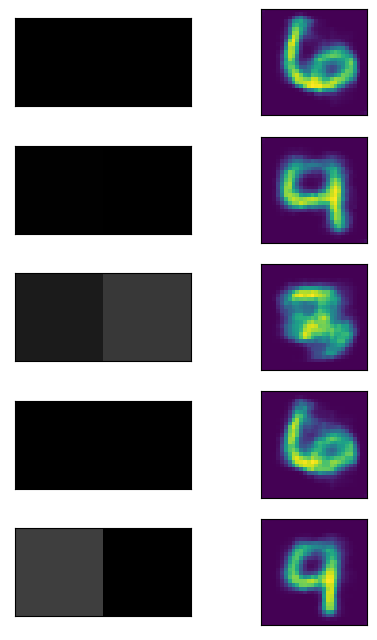

In [24]:
fig,axs=plt.subplots(5,2,figsize=(5,8))
axs=axs.ravel()
for k in range(5):
    axs[2*k].imshow(random_vectors_np[k],cmap='gray', vmin=0, vmax=3)
    axs[2*k+1].imshow(decoded_random[k])
    axs[2*k].set_xticks([])
    axs[2*k].set_yticks([])
    axs[2*k+1].set_xticks([])
    axs[2*k+1].set_yticks([])
# plt.savefig("../images/Random noise generation 2d.png")

In [36]:
gen1024_latent=generate_from_noise(nb_images=1024)
vae.eval()
with torch.no_grad():
    gen1024=vae.decoder(gen1024_latent)
gen1024=gen1024.detach().cpu().numpy().reshape(-1,28,28)

In [37]:
latent1024=gen1024_latent.detach().cpu().numpy().reshape(-1,2)
latent1024.shape

(1024, 2)

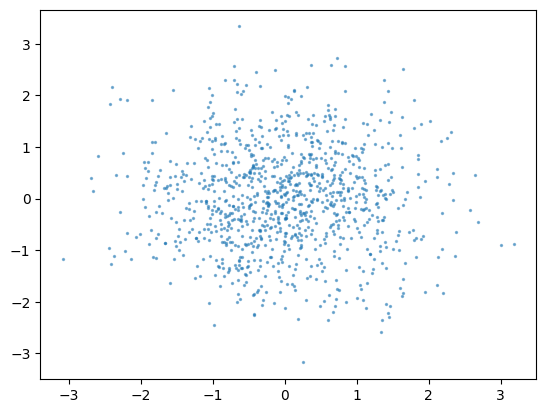

In [38]:
plt.scatter(latent1024[:,0],latent1024[:,1],s=2,alpha=0.5)

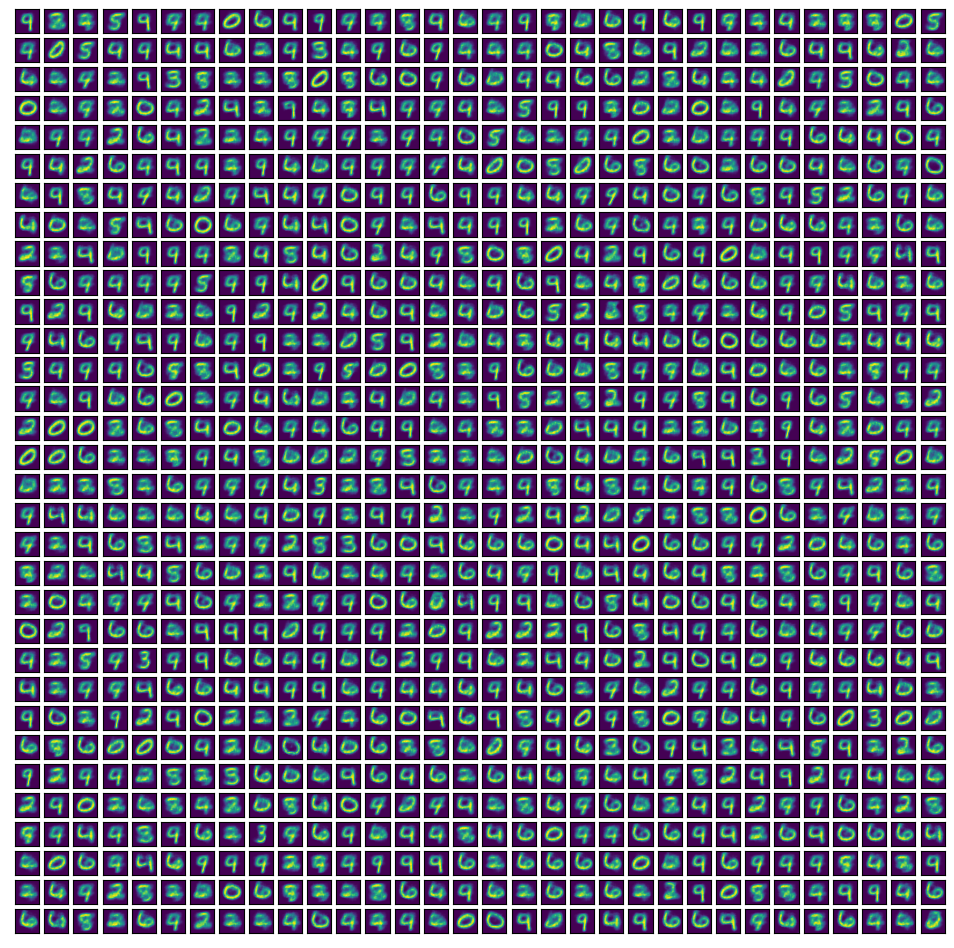

In [76]:
fig,axs=plt.subplots(32,32,figsize=(12,12))
axs=axs.ravel()
for k in range(1024):
    axs[k].imshow(gen1024[k])
    axs[k].set_xticks([])
    axs[k].set_yticks([])

# plt.savefig("../images/Generating random data from noise.png")

## Plot the images in latent space

In [91]:
visualisation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024*2, shuffle=False)

for k,(test_images, test_labels) in enumerate(visualisation_loader):  
    if k==1:
        break

In [9]:
# test_images_np=test_images.detach().cpu().numpy().reshape(1024,28,28)
# np.save("../generated_data/true_MNIST1.npy",test_images_np)

In [99]:
test_images_np.shape

(1024, 1, 28, 28)

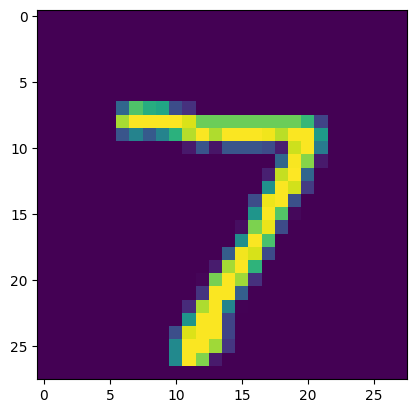

In [101]:
test_images_np=test_images.detach().cpu().numpy().reshape(1024,28,28)
plt.imshow(test_images_np[0])
# np.save("../generated_data/true_MNIST.npy",test_images_np)

In [50]:
vae.eval()
test_images=test_images.to(device)
# data = data.to(device)
# recon, mu, log_var = vae(data)
with torch.no_grad():
    avg,_=vae.encoder(test_images)
avg=avg.cpu().numpy()

Text(0.5, 1.0, 'Latent space with dimension 2')

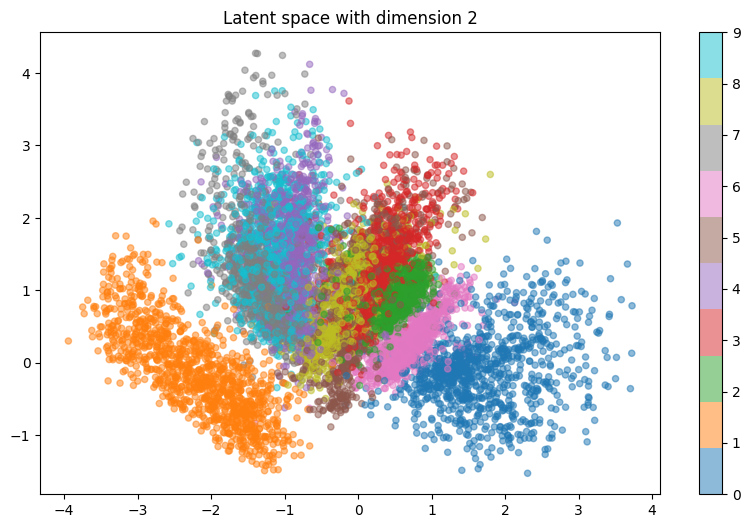

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(avg[:,0],avg[:,1],c=test_labels ,cmap='tab10', alpha=0.5, s=20)
plt.colorbar()
plt.title("Latent space with dimension 2")
# plt.savefig("Latent space dim 2.png")

# 3D Latent space

In [17]:
# !pip install plotly
import pandas as pd
import plotly.express as px

vae.eval()
test_images=test_images.to(device)
# data = data.to(device)
# recon, mu, log_var = vae(data)
with torch.no_grad():
    avg3d,_=vae.encoder(test_images)
avg3d=avg3d.cpu().numpy()

x,y,z=avg3d[:,0],avg3d[:,1],avg3d[:,2]

px.scatter_3d(x=x,y=y,z=z,color=test_labels)

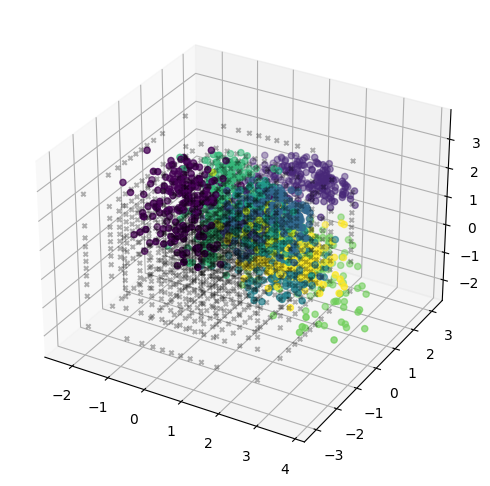

In [33]:
# Using matplotlib
grille=vae.grid
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(projection="3d")
ax.scatter(x,y,z,c=test_labels)
ax.scatter(grille[:,0],grille[:,1],grille[:,2],s=10,marker='x',c="black",alpha=0.3)

# Testing reconstruction

In [18]:
for test_images, test_labels in visualisation_loader:  
    break

test_images=test_images.to(device)
first_images=test_images[:10].to(device)

In [19]:
vae.eval()
reconstructed_images,mu,logvar=vae(first_images)
np_recon=reconstructed_images.view(10,28,28).cpu().detach().numpy()


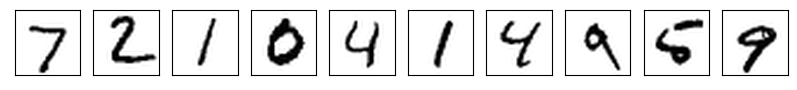

In [24]:
plot_images(first_images.view(10,28,28).cpu().detach().numpy())

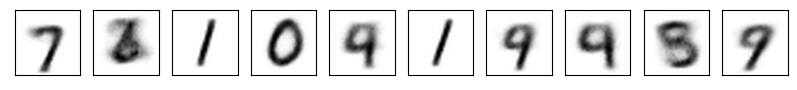

In [25]:
plot_images(np_recon)

# Generating synthetic data

In [30]:
random_point=torch.tensor([-1,1],dtype=torch.float32,device=device)
random_point=random_point.view(1,2)
# random_point.shape

In [31]:
im_out=vae.decoder(random_point)
im_out=im_out.cpu().detach().numpy()
im_out=im_out.reshape(28,28)

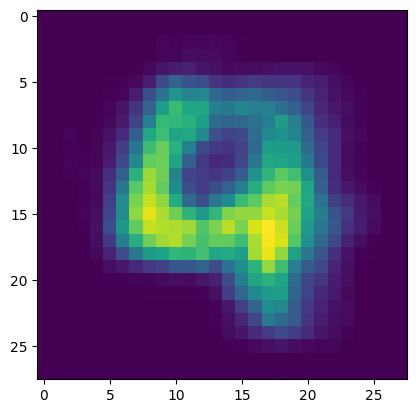

In [32]:
plt.imshow(im_out)

In [ ]:
# for batch_idx, (data, _) in enumerate(train_loader):
#     print(batch_idx)
#     data = data.to(device)
#     optimizer.zero_grad()
#     recon_batch, mu, log_var = vae(data)
#     loss = loss_function(recon_batch, data, mu, log_var)
#     break

# Morphing

In [22]:
import matplotlib,math

In [6]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as=None):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    if save_as:
        plt.savefig(save_as)
    plt.show()

In [ ]:
# plt.scatter(grid[:,0],grid[:,1])

In [7]:

grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(avg[:,0],avg[:,1],c=test_labels, cmap= 'tab10', alpha=0.5, s=20)
plt.colorbar()

plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)

plt.savefig("Morphing grid.png")
# fidle.scrawler.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder(torch.tensor(grid.reshape(-1,1,1,2) ,dtype=torch.float32,device=device))
plot_images(x_reconst.cpu().detach().numpy().reshape(-1,28,28), indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='2d-Latent-morphing.png')



NameError: name 'avg' is not defined

<Figure size 1000x800 with 0 Axes>